# Logistic Regression Analysis of Sales Outcome

This notebook performs a logistic regression analysis to predict sales outcomes based on various variables extracted from sales transcripts. We'll follow a systematic workflow that includes data preparation, addressing multicollinearity, variable selection, model evaluation, and interpretation.

## Table of Contents
1. [Introduction](#introduction)
2. [Data Loading and Preparation](#data-loading-and-preparation)
3. [Exploratory Data Analysis](#exploratory-data-analysis)
4. [Data Preprocessing](#data-preprocessing)
5. [Initial Model Fitting](#initial-model-fitting)
6. [Multicollinearity Check](#multicollinearity-check)
7. [Variable Selection](#variable-selection)
8. [Model Evaluation](#model-evaluation)
9. [Model Interpretation](#model-interpretation)
10. [Interpretation of Results](#interpretation-of-results)
11. [Conclusion](#conclusion)


In [1]:
! pip install pandas numpy matplotlib seaborn scipy scikit-learn statsmodels imbalanced-learn > /dev/null 2>&1


The system cannot find the path specified.


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical libraries
from scipy.stats import chi2_contingency
from scipy.stats import shapiro
from imblearn.over_sampling import SMOTE

# Modeling libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report, 
    roc_curve, 
    roc_auc_score
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.feature_selection import RFE
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Display settings
%matplotlib inline
pd.set_option('display.max_columns', None)


<a id='introduction'></a>
## 1. Introduction

The goal of this analysis is to build a logistic regression model that predicts whether a sales outcome is a win or a loss based on various features extracted from sales call transcripts.

**Variables to be analyzed:**

- **Speech Features:**
  - `total_duration`, `ae_talk_ratio`, `no_talk_ratio_duration`, etc.
- **Question Metrics:**
  - `ae_total_questions`, `ae_question_ratio`, `client_total_questions`, etc.
- **Sentiment and Emotion Metrics:**
  - `sentiment_score`, `emotional_intensity_score`, `anger`, `joy`, etc.

We'll follow these steps:

1. Load and prepare the data.
2. Explore the data and perform initial analysis.
3. Preprocess the data (handle missing values, encode categorical variables, scale features, address class imbalance).
4. Fit an initial logistic regression model with all variables.
5. Check for multicollinearity using Variance Inflation Factor (VIF).
6. Address multicollinearity by removing or combining variables or using regularization techniques.
7. Perform feature selection to identify the most significant predictors.
8. Evaluate the final model's performance.
9. Interpret the model coefficients and provide insights.


In [3]:
# For reproducibility
np.random.seed(42)


<a id='data-loading-and-preparation'></a>
## 2. Data Loading and Preparation

We'll start by loading the dataset from a CSV file and preparing it for analysis.


In [4]:
# Load the dataset
all_transcripts_df = pd.read_csv('transcript_dfs/all_transcripts_df.csv')

# Display the first few rows
all_transcripts_df.head()


,id,title,ae_name,ae_email,sales_outcome,date,meeting_attendees,host_email,transcript_url,video_url,audio_url,total_duration,ae_talk_duration,client_talk_duration,no_talk_duration,ae_talk_ratio,client_talk_ratio,ae_talk_ratio_duration,client_talk_ratio_duration,no_talk_ratio_duration,ae_total_questions,ae_question_ratio,ae_questions_per_minute,ae_first_question_timing_seconds,ae_entropy,ae_gini_coefficient,ae_ave_time_between_questions_seconds,ae_questions_per_segment,client_total_questions,client_question_ratio,client_questions_per_minute,client_first_question_timing_seconds,client_entropy,client_gini_coefficient,client_ave_time_between_questions_seconds,client_questions_per_segment,sentiment_score,emotional_intensity_score,anger,disgust,fear,joy,sadness,surprise,sentiment_balance_ratio,ae_sentiment,client_sentiment,ae_sentiment_variability,client_sentiment_variability,ae_sentiment_trend,client_sentiment_trend,emotional_reciprocity
0,FxuRiyttDW782zH3,Greg <> My Amazon Guy,Shawn Henderson,shawn.henderson@myamazonguy.com,closed_lost,2023/09/19,"sales@motomfg.com, shawn.henderson@myamazonguy...",albert.lapuz@myamazonguy.com,https://app.fireflies.ai/view/FxuRiyttDW782zH3,https://cdn.fireflies.ai/FxuRiyttDW782zH3/vide...,https://cdn.fireflies.ai/FxuRiyttDW782zH3/audi...,3684.41,2543.468,767.444,373.498,0.768208,0.231792,0.690333,0.208295,0.101373,54,0.79,0.88,13.16,0.917867,0.325926,69.15,"8, 1, 12, 1, 5, 5, 3, 6, 5, 8",12,0.21,0.20,15.32,0.878495,0.333333,324.40,"1, 1, 2, 0, 1, 2, 0, 2, 1, 2",0.127632,0.168270,0.019343,0.029039,0.008693,0.037537,0.018408,0.055250,0.955511,0.041697,0.009316,0.368851,0.414361,-0.000135,0.000305,0.088540
1,I7fHBY3mXdH0p1z6,"EPE INDUSTRIES USA, INC. - David <> My Amazon Guy",John Aspinall,john.aspinall@myamazonguy.com,closed_lost,2023/09/21,"christene.mendoza@myamazonguy.com, john.aspina...",christene.mendoza@myamazonguy.com,https://app.fireflies.ai/view/I7fHBY3mXdH0p1z6,https://cdn.fireflies.ai/I7fHBY3mXdH0p1z6/vide...,https://cdn.fireflies.ai/I7fHBY3mXdH0p1z6/audi...,941.32,730.572,146.076,64.672,0.833370,0.166630,0.776114,0.155182,0.068704,29,0.97,1.85,2.83,0.881969,0.382759,30.77,"2, 2, 7, 6, 3, 4, 0, 2, 2, 1",3,0.03,0.19,5.88,0.477121,0.700000,405.13,"1, 0, 0, 0, 0, 1, 0, 0, 1, 0",0.013949,0.201851,0.032581,0.065411,0.007686,0.030010,0.017538,0.048625,0.564766,0.003723,0.047967,0.412839,0.294253,-0.000073,-0.000296,0.274073
2,ZFxjWW0HNgH9LwNW,Marieke <> My Amazon Guy,John Aspinall,john.aspinall@myamazonguy.com,closed_lost,2023/09/21,"marieke@pinkgellac.com, john.aspinall@myamazon...",john.aspinall@myamazonguy.com,https://app.fireflies.ai/view/ZFxjWW0HNgH9LwNW,https://cdn.fireflies.ai/ZFxjWW0HNgH9LwNW/vide...,https://cdn.fireflies.ai/ZFxjWW0HNgH9LwNW/audi...,2007.57,1450.142,410.064,147.364,0.779560,0.220440,0.722337,0.204259,0.073404,60,0.89,1.79,47.30,0.934987,0.300000,32.29,"2, 10, 5, 11, 4, 11, 2, 6, 4, 5",15,0.11,0.45,148.74,0.864831,0.380000,115.58,"3, 2, 2, 1, 2, 1, 0, 3, 1, 0",0.023343,0.196026,0.028274,0.047890,0.009162,0.029954,0.018106,0.062640,0.504200,0.004530,0.024980,0.380418,0.445578,0.000042,0.000056,0.078420
3,jRxXxp3oAK2sJ4S9,Charles <> My Amazon Guy,John Aspinall,john.aspinall@myamazonguy.com,closed_lost,2023/09/22,"charles@rushdirect.net, john.aspinall@myamazon...",john.aspinall@myamazonguy.com,https://app.fireflies.ai/view/jRxXxp3oAK2sJ4S9,https://cdn.fireflies.ai/jRxXxp3oAK2sJ4S9/vide...,https://cdn.fireflies.ai/jRxXxp3oAK2sJ4S9/audi...,1363.86,1190.402,65.352,108.106,0.947958,0.052042,0.872818,0.047917,0.079265,61,0.92,2.68,1.32,0.878401,0.388525,22.09,"4, 1, 0, 3, 6, 10, 9, 7, 15, 6",3,0.08,0.13,299.13,0.477121,0.700000,334.39,"0, 0, 1, 0, 0, 0, 1, 1, 0, 0",-0.016583,0.235935,0.027916,0.078852,0.013298,0.018956,0.018264,0.078648,0.430466,0.002718,-0.008349,0.377271,0.237748,-0.000348,0.000395,-0.275404
4,h1A61pzi1I8uhJHh,Hannah <> My Amazon Guy,Matt Lopez,matt.lopez@myamazonguy.com,closed_lost,2023/09/18,"matt.lopez@myamazonguy.com, hannahamyanderson@...",matt.lopez@myama

**Note:** The dataset is assumed to be loaded successfully. The DataFrame `all_transcripts_df` contains all the necessary variables for analysis.


In [5]:
# Check the shape of the DataFrame
print(f"The dataset contains {all_transcripts_df.shape[0]} rows and {all_transcripts_df.shape[1]} columns.")


The dataset contains 2619 rows and 52 columns.


### Creating the Binary Outcome Variable

We need to create a binary variable `sales_outcome_binary` where:

- `1` represents a **won** sale.
- `0` represents a **lost** sale.


In [6]:
# Map 'sales_outcome' to binary values
all_transcripts_df['sales_outcome_binary'] = all_transcripts_df['sales_outcome'].map({
    'closed_won': 1,
    'closed_lost': 0
})

# Drop rows with missing sales outcome
all_transcripts_df.dropna(subset=['sales_outcome_binary'], inplace=True)

# Verify the mapping
all_transcripts_df['sales_outcome_binary'].value_counts()


0    1952
1     667
Name: sales_outcome_binary, dtype: int64

### Selecting the Variables for Analysis

We'll focus on the variables specified earlier.


In [7]:
# List of variables to analyze
variables = [
    'total_duration', 'ae_talk_ratio', 'no_talk_ratio_duration', 'ae_questions_per_minute',
  	'ae_first_question_timing_seconds', 'ae_entropy', 'ae_ave_time_between_questions_seconds',
  	'client_questions_per_minute', 'client_first_question_timing_seconds', 'client_entropy',
    'client_ave_time_between_questions_seconds', 'sentiment_score', 'anger', 'disgust',
    'fear', 'joy', 'sadness', 'surprise', 'ae_sentiment', 'client_sentiment',
  	'ae_sentiment_variability', 'client_sentiment_variability', 'ae_sentiment_trend',
  	'client_sentiment_trend', 'emotional_reciprocity'
]

# Ensure all variables are present in the DataFrame
variables = [var for var in variables if var in all_transcripts_df.columns]

print(f"Number of variables for analysis: {len(variables)}")


Number of variables for analysis: 25


<a id='exploratory-data-analysis'></a>
## 3. Exploratory Data Analysis

Before modeling, it's essential to understand the data distribution, identify missing values, detect any anomalies, and check for class imbalance.


In [8]:
# Summary statistics
all_transcripts_df[variables + ['sales_outcome_binary']].describe()


,total_duration,ae_talk_ratio,no_talk_ratio_duration,ae_questions_per_minute,ae_first_question_timing_seconds,ae_entropy,ae_ave_time_between_questions_seconds,client_questions_per_minute,client_first_question_timing_seconds,client_entropy,client_ave_time_between_questions_seconds,sentiment_score,anger,disgust,fear,joy,sadness,surprise,ae_sentiment,client_sentiment,ae_sentiment_variability,client_sentiment_variability,ae_sentiment_trend,client_sentiment_trend,emotional_reciprocity,sales_outcome_binary
count,2619.000000,2619.000000,2619.000000,2619.000000,2389.000000,2389.000000,2354.000000,2619.000000,2322.000000,2322.000000,2259.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2616.000000,2619.000000
mean,1831.684535,0.607036,0.150308,0.886678,41.120251,0.791998,78.877294,0.465166,145.757674,0.691088,149.484117,0.076394,0.031352,0.043167,0.013373,0.047713,0.025299,0.070374,0.032666,0.039366,0.336218,0.358355,0.000224,-0.000450,0.103583,0.254677
std,1104.783464,0.246641,0.167865,0.821038,92.473834,0.187817,56.740248,0.407159,250.480131,0.212897,124.997184,0.105472,0.033736,0.028190,0.024313,0.040406,0.023817,0.037843,0.030513,0.218055,0.108807,0.132623,0.042577,0.020146,0.121510,0.435763
min,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,0.000000,0.000000,0.000000,0.440000,-0.782140,0.002899,0.002009,0.001183,0.002275,0.003014,0.002911,-0.369169,-0.792439,0.000000,0.000000,-1.015891,-0.677559,-0.998520,0.000000
25%,1024.804000,0.520873,0.078987,0.490000,0.590000,0.733942,45.620000,0.220000,3.552500,0.587234,79.930000,0.028124,0.021239,0.028509,0.007635,0.031665,0.016492,0.055900,0.016561,0.003736,0.320202,0.337727,-0.000167,0.000000,0.000000,0.000000
50%,1776.842000,0.655622,0.102023,0.820000,4.900000,0.851713,63.840000,0.390000,35.450000,0.746915,119.000000,0.078964,0.026687,0.038361,0.010196,0.042756,0.020700,0.066500,0.031853,0.020768,0.366210,0.393794,0.000000,0.000169,0.093006,0.000000
75%,2573.137000,0.755565,0.138117,1.150000,32.260000,0.915289,93.237500,0.620000,188.175000,0.844753,180.650000,0.125897,0.033689,0.050777,0.014398,0.054462,0.027151,0.078074,0.045865,0.040513,0.395182,0.436464,0.000188,0.000545,0.176441,1.000000
max,10205.200000,1.000000,0.997141,21.540000,1182.240000,0.994034,907.340000,6.520000,3249.780000,0.992017,1886.980000,0.953028,0.829375,0.564967,0.773737,0.813123,0.601632,0.870939,0.491005,6.274217,0.783597,0.636044,1.458988,0.190267,0.672020,1.000000


In [9]:
# Check for missing values
missing_values = all_transcripts_df[variables].isnull().sum().sort_values(ascending=False)
print("Missing values in each variable:")
print(missing_values[missing_values > 0])


Missing values in each variable:
client_ave_time_between_questions_seconds    360
client_first_question_timing_seconds         297
client_entropy                               297
ae_ave_time_between_questions_seconds        265
ae_first_question_timing_seconds             230
ae_entropy                                   230
emotional_reciprocity                          3
dtype: int64


### Handling Missing Values

We'll need to handle missing values appropriately. For simplicity, we'll proceed by dropping rows with missing values in the selected variables.


In [10]:
# Drop rows with missing values in the selected variables
all_transcripts_df.dropna(subset=variables, inplace=True)

# Verify that there are no missing values
print("Missing values after dropping:")
print(all_transcripts_df[variables].isnull().sum().sum())


Missing values after dropping:
0


### Handling Mishandled Transcripts

We'll also check for any transcripts that were mishandled during data collection and remove them from the analysis.

Theses transcripts can be identified by checking the `ae_talk_ratio`. If the ratio is `0` or `1`, it indicates that the speakers were not correctly identified.

In [11]:
# Identify mishandled transcripts
mishandled_transcripts = all_transcripts_df[
    (all_transcripts_df['ae_talk_ratio'] == 0) | (all_transcripts_df['ae_talk_ratio'] == 1)
]

print(f"Number of mishandled transcripts: {len(mishandled_transcripts)}")

# Remove mishandled transcripts from the dataset
all_transcripts_df = all_transcripts_df[
    (all_transcripts_df['ae_talk_ratio'] != 0) & (all_transcripts_df['ae_talk_ratio'] != 1)
]

print(f"Number of transcripts after removing mishandled ones: {len(all_transcripts_df)}")


Number of mishandled transcripts: 50
Number of transcripts after removing mishandled ones: 2143


### Checking Class Balance

We'll check the distribution of the target variable to see if there's any class imbalance.


In [12]:
# Check the distribution of the target variable
print("Distribution of the target variable in the dataset:")
print(all_transcripts_df['sales_outcome_binary'].value_counts())


Distribution of the target variable in the dataset:
0    1558
1     585
Name: sales_outcome_binary, dtype: int64


<a id='data-preprocessing'></a>
## 4. Data Preprocessing

### Splitting the Data

We'll split the data into features (`X`) and target (`y`).


In [13]:
# Features and target
X = all_transcripts_df[variables]
y = all_transcripts_df['sales_outcome_binary']


### Standardizing the Features

Logistic regression can benefit from feature scaling, especially when regularization is used.


In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for convenience
X_scaled = pd.DataFrame(X_scaled, columns=variables)


### Splitting into Training and Test Sets

We'll split the data into training and test sets to evaluate the model's performance on unseen data.


In [15]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Training set size: 1714 samples
Test set size: 429 samples


### Addressing Class Imbalance with SMOTE

The dataset has an imbalanced target variable, which can affect the performance of the model. We'll use SMOTE (Synthetic Minority Oversampling Technique) to balance the classes in the training set.


In [16]:
# Check the distribution of the target variable in the training set
print("Distribution of the target variable in the training set:")
print(y_train.value_counts())

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the class distribution after applying SMOTE
print("Distribution of the target variable after applying SMOTE:")
print(y_train_smote.value_counts())


Distribution of the target variable in the training set:
0    1246
1     468
Name: sales_outcome_binary, dtype: int64
Distribution of the target variable after applying SMOTE:
1    1246
0    1246
Name: sales_outcome_binary, dtype: int64


<a id='initial-model-fitting'></a>
## 5. Initial Model Fitting

We'll fit an initial logistic regression model using all variables.


In [17]:
# Initialize the logistic regression model
log_reg = LogisticRegression(penalty='none', solver='lbfgs', max_iter=1000)

# Fit the model on the SMOTE-balanced training data
log_reg.fit(X_train_smote, y_train_smote)


LogisticRegression(max_iter=1000, penalty='none')

<a id='multicollinearity-check'></a>
## 6. Multicollinearity Check

Multicollinearity can inflate the variance of coefficient estimates and make the model unstable. We'll calculate the Variance Inflation Factor (VIF) for each feature.

**Note:** VIF is calculated on the original training data before SMOTE is applied.


In [18]:
# Function to calculate VIF
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [
        variance_inflation_factor(X.values, i) for i in range(X.shape[1])
    ]
    return vif_data

# Calculate VIF on the original training set
vif_df = calculate_vif(X_train)

print("Variance Inflation Factor (VIF) for each feature:")
vif_df.sort_values('VIF', ascending=False)


Variance Inflation Factor (VIF) for each feature:


,Feature,VIF
11,sentiment_score,4.554816
3,ae_questions_per_minute,2.637383
13,disgust,2.549747
18,ae_sentiment,2.532563
15,joy,2.526571
9,client_entropy,2.486274
7,client_questions_per_minute,2.360310
19,client_sentiment,2.076151
6,ae_ave_time_between_questions_seconds,2.068961
0,total_duration,2.044423


### Addressing Multicollinearity

Variables with VIF values greater than 5 indicate potential multicollinearity issues. We'll consider removing these variables.


In [19]:
# Identify variables with VIF > 5
high_vif_features = vif_df[vif_df['VIF'] > 5]['Feature']
print("Features with VIF > 5:")
print(high_vif_features.tolist())


Features with VIF > 5:
[]


In [20]:
# Remove high VIF features
X_train_reduced = X_train.drop(columns=high_vif_features)
X_test_reduced = X_test.drop(columns=high_vif_features)

# Apply SMOTE to the reduced training data
X_train_reduced_smote, y_train_smote = smote.fit_resample(X_train_reduced, y_train)

# Recalculate VIF after removal
vif_df_reduced = calculate_vif(X_train_reduced)
print("VIF after removing high VIF features:")
vif_df_reduced.sort_values('VIF', ascending=False)


VIF after removing high VIF features:


,Feature,VIF
11,sentiment_score,4.554816
3,ae_questions_per_minute,2.637383
13,disgust,2.549747
18,ae_sentiment,2.532563
15,joy,2.526571
9,client_entropy,2.486274
7,client_questions_per_minute,2.360310
19,client_sentiment,2.076151
6,ae_ave_time_between_questions_seconds,2.068961
0,total_duration,2.044423


<a id='variable-selection'></a>
## 7. Variable Selection

To further refine the model, we'll perform feature selection using Lasso Regularization.

### Lasso Regularization


In [21]:
# Initialize logistic regression with L1 penalty
log_reg_lasso = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

# Fit the model on the SMOTE-balanced reduced training data
log_reg_lasso.fit(X_train_reduced_smote, y_train_smote)

# Get the coefficients
lasso_coefficients = pd.DataFrame({
    'Feature': X_train_reduced.columns,
    'Coefficient': log_reg_lasso.coef_[0]
})

# Identify selected features
selected_features = lasso_coefficients[lasso_coefficients['Coefficient'] != 0]['Feature'].tolist()
print(f"Selected {len(selected_features)} features using Lasso: {selected_features}")


Selected 25 features using Lasso: ['total_duration', 'ae_talk_ratio', 'no_talk_ratio_duration', 'ae_questions_per_minute', 'ae_first_question_timing_seconds', 'ae_entropy', 'ae_ave_time_between_questions_seconds', 'client_questions_per_minute', 'client_first_question_timing_seconds', 'client_entropy', 'client_ave_time_between_questions_seconds', 'sentiment_score', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'ae_sentiment', 'client_sentiment', 'ae_sentiment_variability', 'client_sentiment_variability', 'ae_sentiment_trend', 'client_sentiment_trend', 'emotional_reciprocity']


### Fitting the Final Model

We'll fit the logistic regression model using only the selected features.


In [22]:
# Subset the training and test sets
X_train_final = X_train_reduced[selected_features]
X_test_final = X_test_reduced[selected_features]

# Apply SMOTE to the final training data
X_train_final_smote, y_train_smote = smote.fit_resample(X_train_final, y_train)

# Initialize the logistic regression model with regularization
final_model = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000)

# Fit the final model
final_model.fit(X_train_final_smote, y_train_smote)


LogisticRegression(max_iter=1000)

<a id='model-evaluation'></a>
## 8. Model Evaluation

We'll evaluate the model's performance on the test set.


In [23]:
# Predict on the test set
y_pred = final_model.predict(X_test_final)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy:.4f}")


Test set accuracy: 0.6014


In [24]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.60      0.69       312
           1       0.36      0.62      0.46       117

    accuracy                           0.60       429
   macro avg       0.58      0.61      0.57       429
weighted avg       0.68      0.60      0.62       429



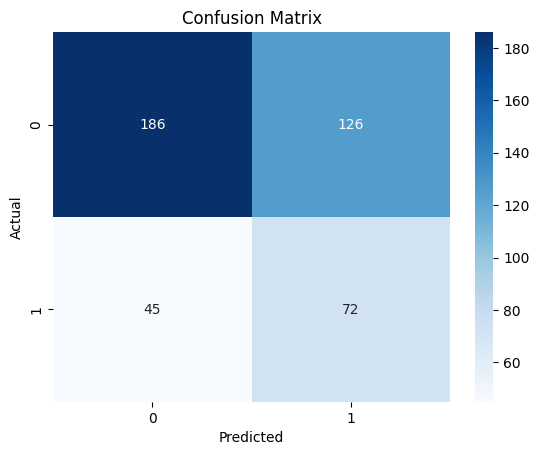

In [29]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


ROC AUC Score: 0.6547


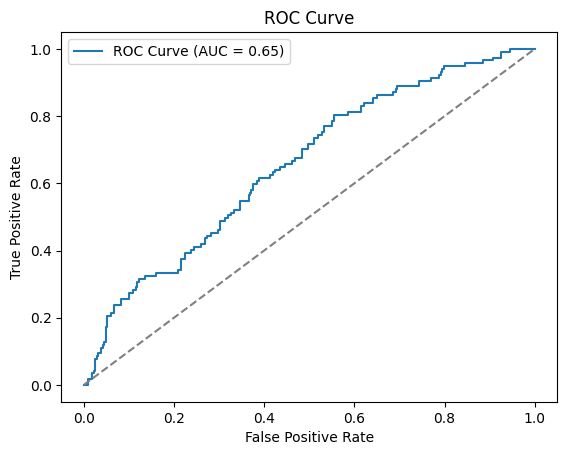

In [26]:
# ROC Curve and AUC
y_pred_proba = final_model.predict_proba(X_test_final)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {auc_score:.4f}")

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


<a id='model-interpretation'></a>
## 9. Model Interpretation

### Coefficient Analysis

We'll examine the coefficients of the final model to understand the impact of each feature.


In [27]:
# Recalculate VIFs for all features in the initial model
vif_df_initial = calculate_vif(X_train)

# Create a DataFrame for coefficients of the final model
coefficients = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': final_model.coef_[0]
})

# Calculate odds ratios for included features
coefficients['Odds Ratio'] = np.exp(coefficients['Coefficient'])

# Add a column to indicate that these features were included
coefficients['Included in Final Model'] = 'Yes'

# For features that were dropped, set coefficients and odds ratios to NaN
all_features = X_train.columns.tolist()
dropped_features = [feature for feature in all_features if feature not in selected_features]

# Create a DataFrame for dropped features
dropped_df = pd.DataFrame({
    'Feature': dropped_features,
    'Coefficient': [np.nan]*len(dropped_features),
    'Odds Ratio': [np.nan]*len(dropped_features),
    'Included in Final Model': 'No'
})

# Combine the coefficients of included and dropped features
all_features_df = pd.concat([coefficients, dropped_df], ignore_index=True)

# Merge with VIF values
# Rename VIF column for clarity
vif_df_initial.rename(columns={'VIF': 'VIF Score'}, inplace=True)

# Merge VIFs with all_features_df
all_features_df = all_features_df.merge(vif_df_initial[['Feature', 'VIF Score']], on='Feature', how='left')

# Sort the DataFrame for better readability
all_features_df.sort_values(by='Included in Final Model', ascending=False, inplace=True)

# Reset index
all_features_df.reset_index(drop=True, inplace=True)

# Display the final table
all_features_df[['Feature', 'Included in Final Model', 'Coefficient', 'Odds Ratio', 'VIF Score']]


,Feature,Included in Final Model,Coefficient,Odds Ratio,VIF Score
0,total_duration,Yes,0.348029,1.416273,2.044423
1,disgust,Yes,-0.327828,0.720487,2.549747
2,client_sentiment_trend,Yes,0.304399,1.355810,1.448129
3,ae_sentiment_trend,Yes,0.320135,1.377313,1.065590
4,client_sentiment_variability,Yes,0.011196,1.011259,1.541042
5,ae_sentiment_variability,Yes,-0.113043,0.893112,1.771832
6,client_sentiment,Yes,0.190567,1.209935,2.076151
7,ae_sentiment,Yes,0.191486,1.211048,2.532563
8,surprise,Yes,-0.096123,0.908352,1.592162
9,sadness,Yes,-0.061760,0.940108,1.683736


### Coefficient Table with All Features

The table below includes all the features from the initial model, indicating whether they were included in the final model. Coefficients and odds ratios are shown for the features included in the final model. For dropped features, these values are marked as N/A. The VIF scores are provided for all features.

**Table: Coefficients, Odds Ratios, and VIF Scores**


In [28]:
# Display the table
display(all_features_df[['Feature', 'Included in Final Model', 'Coefficient', 'Odds Ratio', 'VIF Score']])


,Feature,Included in Final Model,Coefficient,Odds Ratio,VIF Score
0,total_duration,Yes,0.348029,1.416273,2.044423
1,disgust,Yes,-0.327828,0.720487,2.549747
2,client_sentiment_trend,Yes,0.304399,1.355810,1.448129
3,ae_sentiment_trend,Yes,0.320135,1.377313,1.065590
4,client_sentiment_variability,Yes,0.011196,1.011259,1.541042
5,ae_sentiment_variability,Yes,-0.113043,0.893112,1.771832
6,client_sentiment,Yes,0.190567,1.209935,2.076151
7,ae_sentiment,Yes,0.191486,1.211048,2.532563
8,surprise,Yes,-0.096123,0.908352,1.592162
9,sadness,Yes,-0.061760,0.940108,1.683736


### **Interpretation**

Based on the model's performance and the coefficients obtained from the logistic regression, we can draw several insights:

#### **Model Performance:**

- **Test Set Accuracy:** The model achieved an accuracy of **60.14%** on the test set.
- **ROC AUC Score:** The ROC AUC score is **0.6547**, indicating a moderate ability to distinguish between won and lost sales.
- **Classification Report & Confusion Matrix:**
  - **Precision and Recall:** The model has higher precision for class `0` (lost sales) and higher recall for class `1` (won sales), suggesting it better identifies actual won sales but may misclassify some lost sales as won.
  - **Confusion Matrix:** The model correctly identified 186 lost sales and 72 won sales but misclassified 126 lost sales as won and 45 won sales as lost.

#### **Coefficient Analysis:**

##### **Positive Coefficients (Increase Odds of Winning):**

1. **`total_duration` (0.3480):**
   - **Odds Ratio:** 1.4163
   - **Interpretation:** Longer call durations are associated with higher chances of winning a sale. Each standard deviation increase in call duration increases the odds of winning by approximately 41.6%.

2. **`client_sentiment_trend` (0.3044):**
   - **Odds Ratio:** 1.3558
   - **Interpretation:** An upward trend in client sentiment during the call increases the likelihood of a win.

3. **`ae_sentiment_trend` (0.3201):**
   - **Odds Ratio:** 1.3773
   - **Interpretation:** A positive trend in AE sentiment correlates with higher sales success.

4. **`client_sentiment` (0.1906):**
   - **Odds Ratio:** 1.2099
   - **Interpretation:** Higher average client sentiment scores are linked to increased chances of winning.

5. **`ae_sentiment` (0.1915):**
   - **Odds Ratio:** 1.2110
   - **Interpretation:** Higher average AE sentiment scores contribute positively to winning sales.

6. **`client_entropy` (0.2204):**
   - **Odds Ratio:** 1.2466
   - **Interpretation:** Greater variability in the client's speech patterns is associated with higher win rates.

7. **`ae_entropy` (0.2140):**
   - **Odds Ratio:** 1.2386
   - **Interpretation:** Greater variability in the AE's speech patterns correlates with increased sales success.

8. **`anger` (0.2075):**
   - **Odds Ratio:** 1.2306
   - **Interpretation:** Slight increases in expressions of anger are unexpectedly linked to higher odds of winning, possibly indicating passionate engagement.

##### **Negative Coefficients (Decrease Odds of Winning):**

1. **`disgust` (-0.3278):**
   - **Odds Ratio:** 0.7205
   - **Interpretation:** Higher levels of disgust are strongly associated with lost sales. Each standard deviation increase decreases the odds of winning by approximately 27.9%.

2. **`ae_questions_per_minute` (-0.2560):**
   - **Odds Ratio:** 0.7741
   - **Interpretation:** A higher frequency of AE questions per minute may overwhelm the client, reducing success rates.

3. **`ae_sentiment_variability` (-0.1130):**
   - **Odds Ratio:** 0.8931
   - **Interpretation:** Greater variability in AE sentiment negatively impacts sales outcomes.

4. **`emotional_reciprocity` (-0.1068):**
   - **Odds Ratio:** 0.8987
   - **Interpretation:** Higher emotional reciprocity between AE and client slightly decreases the likelihood of winning, suggesting AEs should lead the emotional tone.

5. **`no_talk_ratio_duration` (-0.0849):**
   - **Odds Ratio:** 0.9186
   - **Interpretation:** Longer periods of silence during calls reduce the chances of winning.

##### **Small Magnitude Coefficients:**

Features such as `fear`, `joy`, `sadness`, `surprise`, `sentiment_score`, `ae_talk_ratio`, `client_first_question_timing_seconds`, `client_questions_per_minute`, `ae_ave_time_between_questions_seconds`, and `client_ave_time_between_questions_seconds` have coefficients with smaller magnitudes (closer to zero). While these features do have some effect on the sales outcome, their individual impact is relatively minor compared to the features discussed above.

- **Interpretation:** These small magnitude coefficients suggest that these features have a less significant influence on the likelihood of winning a sale. They may contribute to the overall model but do not substantially alter the odds of winning when considered individually.

#### **Variance Inflation Factor (VIF):**

- All included features have VIF scores less than 5, suggesting multicollinearity is not a significant issue in the final model.

---

<a id='conclusion'></a>
## 10. Conclusion

Our analysis has identified key factors that influence sales outcomes. By understanding these factors, we can derive actionable insights for both the executive team and the data team.

### **Actionable Insights for the Executive Team**

1. **Enhance Emotional Intelligence Training:**

   - **Balance Expressions of Positive Emotions:**
     - **Manage Overenthusiasm:**
       - Train Account Executives (AEs) to express genuine enthusiasm without overdoing it, as excessive expressions of joy may be perceived as insincere or unprofessional, potentially decreasing sales success.
     - **Cultivate Genuine Positivity:**
       - Encourage AEs to maintain a positive demeanor that aligns authentically with the client's needs and the conversation's context.

   - **Address Negative Client Emotions Promptly:**
     - **Recognize Signs of Disgust:**
       - Equip AEs with strategies to identify and mitigate expressions of disgust from clients, which are strongly linked to lost sales.
     - **Turn Challenges into Opportunities:**
       - Use client expressions of anger as opportunities to build trust by addressing concerns effectively.

   - **Maintain Emotional Consistency:**
     - **Reduce AE Sentiment Variability:**
       - Consistent emotional tone from AEs fosters trust and confidence. Training should focus on helping AEs manage their emotions throughout the call.

2. **Optimize Communication Patterns:**

   - **Effective Questioning Techniques:**
     - **Quality Over Quantity:**
       - Avoid overwhelming clients with too many questions per minute. Focus on meaningful, open-ended questions that encourage dialogue.
     - **Pace the Conversation:**
       - Allow adequate time between questions for clients to respond thoughtfully.

   - **Enhance Client Engagement:**
     - **Encourage Positive Client Sentiment Trends:**
       - Implement strategies to keep the client's sentiment improving throughout the call, increasing the likelihood of a win.

3. **Improve Call Dynamics:**

   - **Leverage Call Duration:**
     - **Strategically Extend Conversations:**
       - Longer calls are associated with higher win rates. AEs should aim to keep clients engaged in meaningful discussions without unnecessary prolongation.

   - **Increase Speech Variability:**
     - **Foster Dynamic Interactions:**
       - Encourage AEs to vary their speech patterns (e.g., tone, pace) to maintain client interest and adapt to the flow of conversation.

   - **Minimize Unproductive Silence:**
     - **Maintain Engagement:**
       - Reduce periods of silence during calls, as they can lead to decreased client interest and lower chances of winning.

4. **Lead the Emotional Tone:**

   - **Manage Emotional Reciprocity:**
     - **Set a Positive Tone:**
       - AEs should aim to lead the emotional atmosphere rather than simply mirror the client's emotions, as higher emotional reciprocity may not favor sales outcomes.

5. **Address Ambiguous Emotional Cues:**

   - **Interpret Expressions of Anger Constructively:**
     - **Engage Proactively:**
       - View expressions of anger as indicators of client concerns that, when addressed effectively, can lead to increased trust and higher odds of closing the sale.

### **Recommendations for the IT Data Team**

1. **Model Refinement and Enhancement:**

   - **Investigate Unexpected Findings:**
     - **Joy's Negative Impact:**
       - Explore why higher expressions of joy correlate with decreased sales success. This could involve analyzing the context in which joy is expressed.
     - **Non-linear Relationships:**
       - Consider using models that can capture non-linear relationships or interaction effects between variables for more nuanced insights.

   - **Feature Engineering:**
     - **Create Interaction Terms:**
       - Develop new features that represent interactions between key variables (e.g., combining sentiment trends with speech patterns).

2. **Data Quality and Emotion Detection:**

   - **Improve Emotion Classification:**
     - **Refine Algorithms:**
       - Enhance the accuracy of emotion detection to ensure that emotions like joy, anger, and fear are correctly identified and contextualized.
     - **Contextual Analysis:**
       - Incorporate natural language processing techniques to understand the context of emotional expressions.

3. **Address Class Imbalance and Model Performance:**

   - **Experiment with Advanced Techniques:**
     - **Alternative Resampling Methods:**
       - Try different methods to handle class imbalance, such as SMOTE combined with Tomek Links or ensemble techniques.
     - **Algorithm Diversification:**
       - Evaluate other algorithms (e.g., Random Forest, Gradient Boosting) that might capture complex patterns better.

4. **Enhance Model Interpretability:**

   - **Use Explainable AI Tools:**
     - **SHAP Values:**
       - Apply SHAP (SHapley Additive exPlanations) to understand the contribution of each feature at the individual prediction level.
     - **LIME:**
       - Utilize LIME (Local Interpretable Model-agnostic Explanations) for interpreting model predictions.

5. **Continuous Monitoring and Validation:**

   - **Update Models Regularly:**
     - **Incorporate New Data:**
       - Retrain models periodically with new data to maintain accuracy and relevance.
     - **Monitor Performance Metrics:**
       - Keep track of model performance over time to detect and address any degradation.

### **Final Thoughts**

By integrating these insights, the executive team can enhance sales strategies, and the data team can refine analytical models for better performance. Collaboration between teams is essential to translate data-driven findings into practical improvements.

---

**Next Steps:**

- **For the Executive Team:**
  - **Training Programs:**
    - Develop workshops focused on emotional intelligence, effective communication, and client engagement strategies.
  - **Feedback Mechanisms:**
    - Implement systems for AEs to receive feedback on call performance, focusing on the key factors identified.

- **For the Data Team:**
  - **Research and Development:**
    - Prioritize investigating unexpected findings and enhancing model capabilities.
  - **Cross-functional Collaboration:**
    - Work closely with AEs to understand the nuances of sales interactions, providing deeper context for data analysis.

---

By acting on these recommendations, the organization can empower the sales team to connect more effectively with clients, ultimately driving better sales outcomes.

